In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


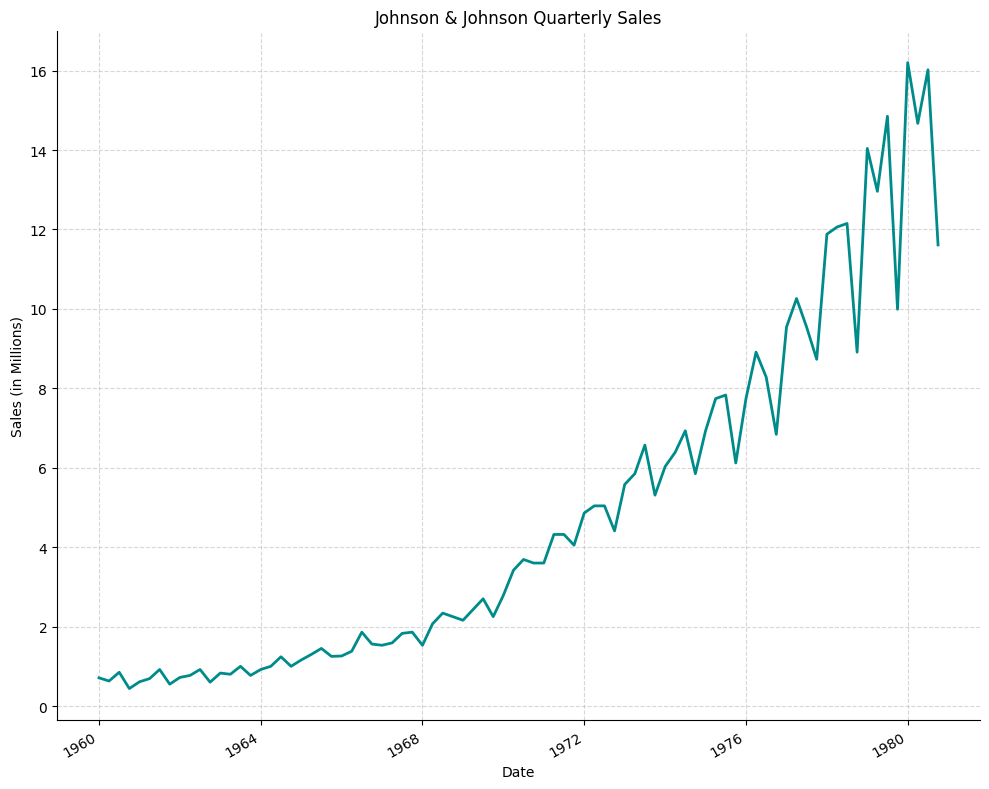

ADF Test p-value (Original Series): 1.0
ADF Test p-value (1st Difference): 0.9088542416911305
ADF Test p-value (2nd Difference): 0.006051099869603682


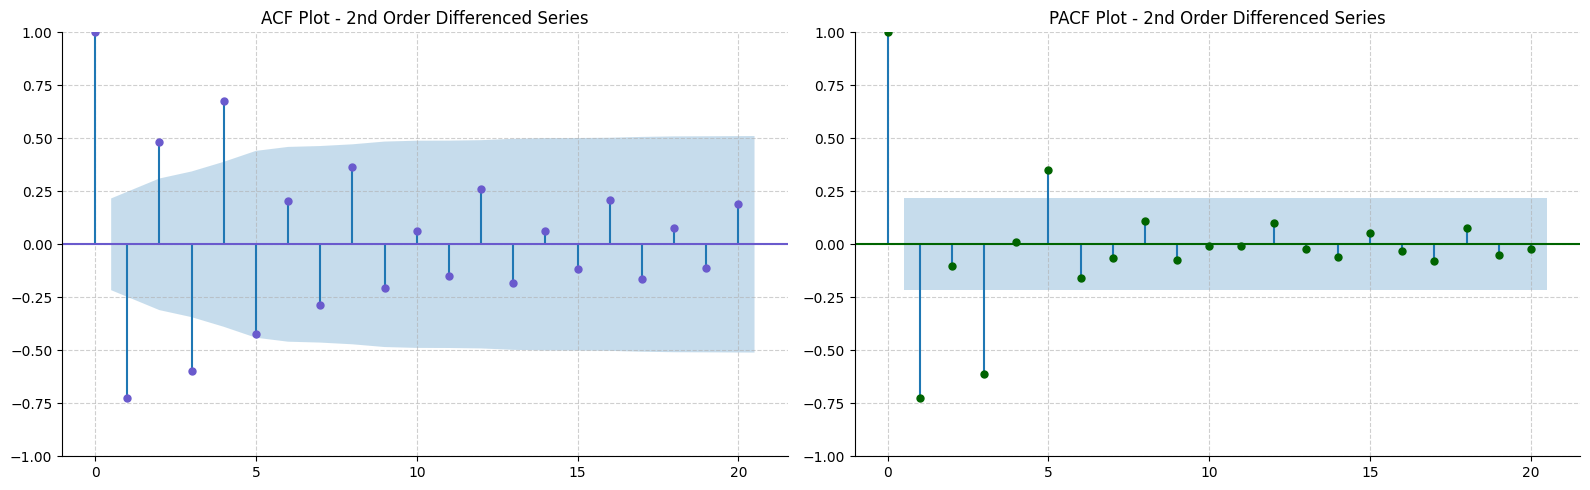

In [2]:
# ----------------------------------------
# Import Required Libraries for Analysis
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# Set global plot style
plt.rcParams['figure.figsize'] = [10, 8]

# ---------------------------------------------------
# Load Johnson & Johnson Quarterly Sales Data
# ---------------------------------------------------
jj_data = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_data.columns = ['Date', 'Sales']
jj_data['Date'] = pd.to_datetime(jj_data['Date'])
jj_data.set_index('Date', inplace=True)

# ---------------------------------------------------
# Visualize the Original Time Series
# ---------------------------------------------------
jj_data['Sales'].plot(kind='line', title='Johnson & Johnson Quarterly Sales',
                      color='darkcyan', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Sales (in Millions)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Augmented Dickey-Fuller Test for Stationarity
# ---------------------------------------------------
adf_orig = adfuller(jj_data['Sales'].dropna())
print("ADF Test p-value (Original Series):", adf_orig[1])

adf_1st_diff = adfuller(jj_data['Sales'].diff().dropna())
print("ADF Test p-value (1st Difference):", adf_1st_diff[1])

adf_2nd_diff = adfuller(jj_data['Sales'].diff().dropna().diff().dropna())
print("ADF Test p-value (2nd Difference):", adf_2nd_diff[1])

# Prepare second-order differenced series for ACF/PACF
sales_diff_2nd = jj_data['Sales'].diff().dropna().diff().dropna()

# ---------------------------------------------------
# Plot ACF and PACF for Stationary Series
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(sales_diff_2nd, lags=20, ax=axes[0], color='slateblue')
axes[0].set_title("ACF Plot - 2nd Order Differenced Series")

plot_pacf(sales_diff_2nd, lags=20, ax=axes[1], color='darkgreen')
axes[1].set_title("PACF Plot - 2nd Order Differenced Series")

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


Best ARIMA Order (p, d=2, q): (3, 2, 3)


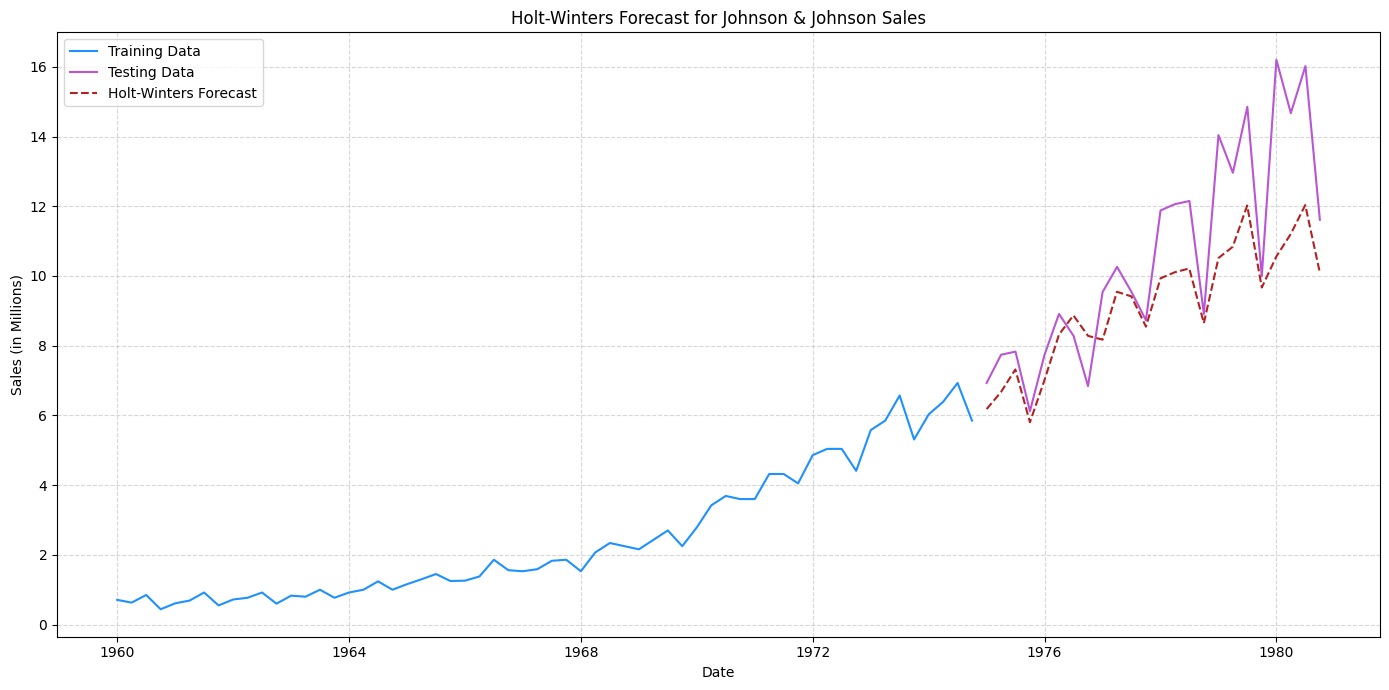

Holt-Winters Forecast Accuracy:
MAE  : 1.5787
MSE  : 4.4277
RMSE : 2.1042


In [3]:
# ------------------------------------------------------
# Grid Search to Identify Optimal ARIMA(p, 2, q) Model
# ------------------------------------------------------
lowest_aic = float("inf")
best_order = None
best_arima_model = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(jj_data['Sales'], order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_order = (p, 2, q)
                best_arima_model = model
        except:
            continue

print("Best ARIMA Order (p, d=2, q):", best_order)

# ------------------------------------------------------
# Holt-Winters Exponential Smoothing Model Forecasting
# ------------------------------------------------------
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create moving average and EWMA columns for visualization
jj_smoothed = jj_data.copy()
jj_smoothed['SMA_6'] = jj_smoothed['Sales'].rolling(window=6).mean()
jj_smoothed['SMA_12'] = jj_smoothed['Sales'].rolling(window=12).mean()
jj_smoothed['EWMA_12'] = jj_smoothed['Sales'].ewm(span=12, adjust=False).mean()

# Split the dataset into training and test sets
n_test = 24
train_data = jj_smoothed[:-n_test]
test_data = jj_smoothed[-n_test:]

# Fit Holt-Winters Model on training data
holt_winters_model = ExponentialSmoothing(
    train_data['Sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24
).fit()

# Forecast for next 24 quarters
n_forecast = 24
forecast_index = pd.date_range(
    start=train_data.index[-1] + pd.DateOffset(months=3),
    periods=n_forecast,
    freq='QS'
)
forecast_values = holt_winters_model.forecast(n_forecast)
hw_forecast = pd.Series(forecast_values.values, index=forecast_index, name='HW Forecast')

# ------------------------------------------------------
# Plot Forecast vs Actual Quarterly Sales
# ------------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Sales'], label='Training Data', color='dodgerblue')
plt.plot(test_data.index, test_data['Sales'], label='Testing Data', color='mediumorchid')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='firebrick', linestyle='--')
plt.title("Holt-Winters Forecast for Johnson & Johnson Sales")
plt.xlabel("Date")
plt.ylabel("Sales (in Millions)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Evaluate Holt-Winters Forecast Performance
# ------------------------------------------------------
hw_eval = hw_forecast[:len(test_data)]
mae = mean_absolute_error(test_data['Sales'], hw_eval)
mse = mean_squared_error(test_data['Sales'], hw_eval)
rmse = np.sqrt(mse)

print("Holt-Winters Forecast Accuracy:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")


**Build an RNN based model (LSTM, GRU)**

Epoch 1/50
8/8 - 5s - 567ms/step - loss: 0.1288 - val_loss: 0.5191
Epoch 2/50
8/8 - 0s - 15ms/step - loss: 0.0856 - val_loss: 0.3420
Epoch 3/50
8/8 - 0s - 21ms/step - loss: 0.0781 - val_loss: 0.2036
Epoch 4/50
8/8 - 0s - 32ms/step - loss: 0.0632 - val_loss: 0.1537
Epoch 5/50
8/8 - 0s - 17ms/step - loss: 0.0379 - val_loss: 0.1035
Epoch 6/50
8/8 - 0s - 19ms/step - loss: 0.0328 - val_loss: 0.1540
Epoch 7/50
8/8 - 0s - 21ms/step - loss: 0.0265 - val_loss: 0.1067
Epoch 8/50
8/8 - 0s - 32ms/step - loss: 0.0371 - val_loss: 0.0959
Epoch 9/50
8/8 - 0s - 22ms/step - loss: 0.0305 - val_loss: 0.1104
Epoch 10/50
8/8 - 0s - 16ms/step - loss: 0.0332 - val_loss: 0.1002
Epoch 11/50
8/8 - 0s - 18ms/step - loss: 0.0367 - val_loss: 0.1187
Epoch 12/50
8/8 - 0s - 23ms/step - loss: 0.0331 - val_loss: 0.1172
Epoch 13/50
8/8 - 0s - 16ms/step - loss: 0.0296 - val_loss: 0.0960
Epoch 14/50
8/8 - 0s - 18ms/step - loss: 0.0318 - val_loss: 0.1236
Epoch 15/50
8/8 - 0s - 16ms/step - loss: 0.0316 - val_loss: 0.1027
Epo

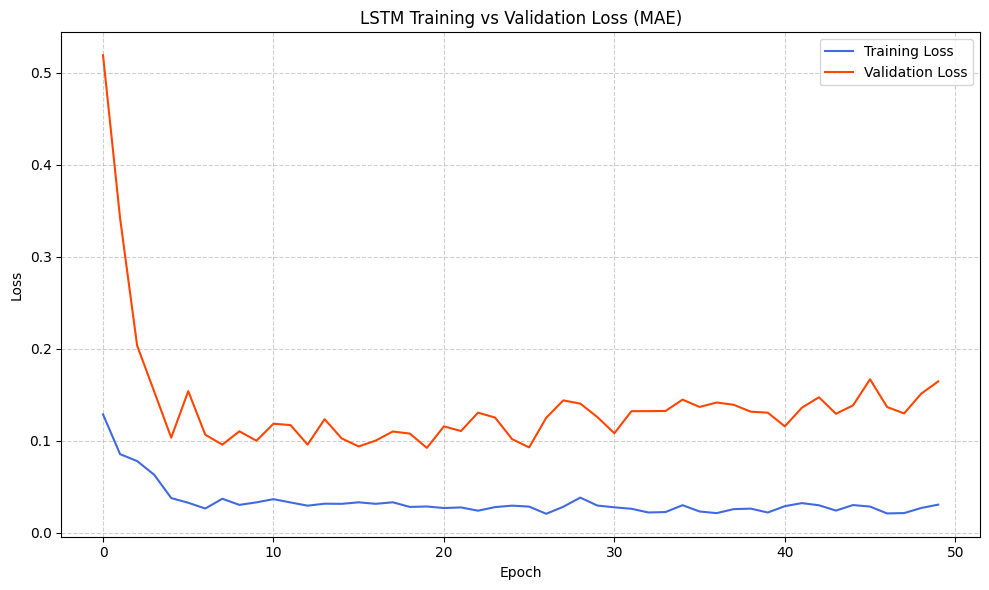

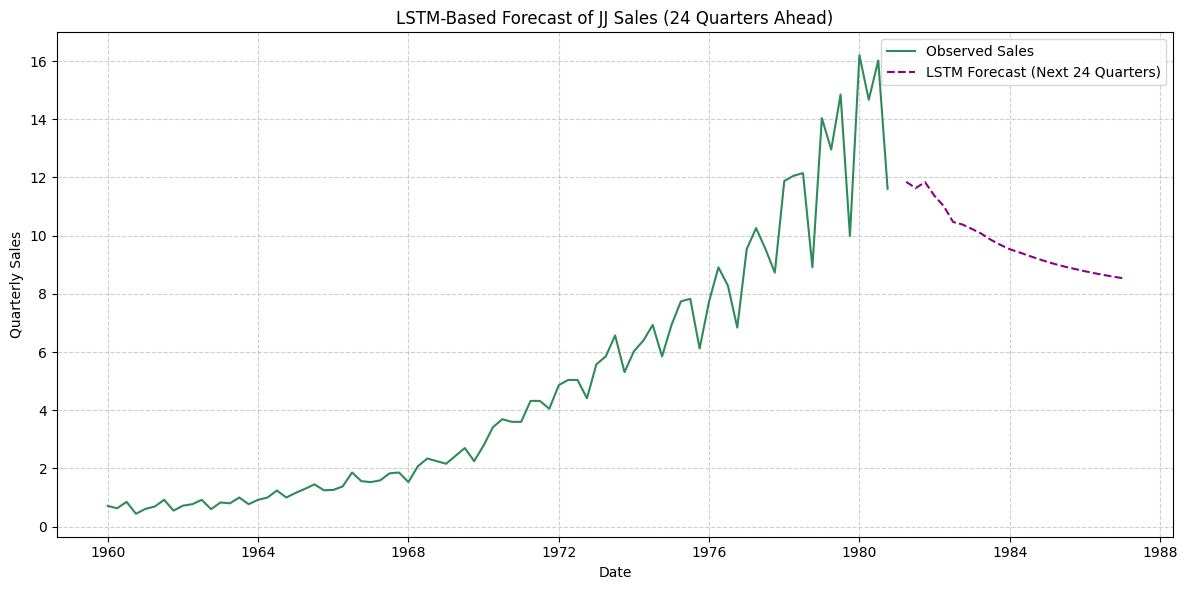

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
LSTM Model Performance on Test Set:
MAE  : 2.5952
MSE  : 9.1154
RMSE : 3.0192
R²   : -0.5579


In [4]:
from pandas import DataFrame, concat
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# -------------------------------------------------
# Load and Normalize the JJ Quarterly Sales Data
# -------------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(jj_df[['value']].values.astype('float32'))

# -------------------------------------------------
# Convert Time Series to Supervised Format
# -------------------------------------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

supervised_df = series_to_supervised(scaled_values, n_in=6, n_out=1)

# -------------------------------------------------
# Prepare Data for Training and Testing
# -------------------------------------------------
X_all = supervised_df.iloc[:, :-1]
y_all = supervised_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------------------------
# Build and Train the LSTM Model
# -------------------------------------------------
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mae', optimizer='adam')

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -------------------------------------------------
# Visualize Training and Validation Loss
# -------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orangered')
plt.title('LSTM Training vs Validation Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Generate Forecasts for the Next 24 Quarters
# -------------------------------------------------
last_input = scaled_values[-6:]
future_preds = []

for _ in range(24):
    seq_input = last_input.reshape((1, 6, 1))
    next_pred = lstm_model.predict(seq_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_input = np.append(last_input[1:], [[next_pred]], axis=0)

future_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_known_date = jj_df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=3), periods=24, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Forecast'])

# -------------------------------------------------
# Plot Observed vs Forecasted Sales
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['value'], label='Observed Sales', color='seagreen')
plt.plot(future_df.index, future_df['Forecast'], label='LSTM Forecast (Next 24 Quarters)', color='darkmagenta', linestyle='--')
plt.title('LSTM-Based Forecast of JJ Sales (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Quarterly Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Evaluate Model Performance
# -------------------------------------------------
y_pred_scaled = lstm_model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM Model Performance on Test Set:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0559 - val_loss: 0.1798
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - val_loss: 0.0239
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0043 - val_loss: 0.0387
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0186
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4461e-04 - val_loss: 0.0187
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0230
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.2666e-04 - val_loss: 0.0180
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 0.0172
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.9693e-04 - val_loss: 0.0177
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0199
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 0.0201
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_lo

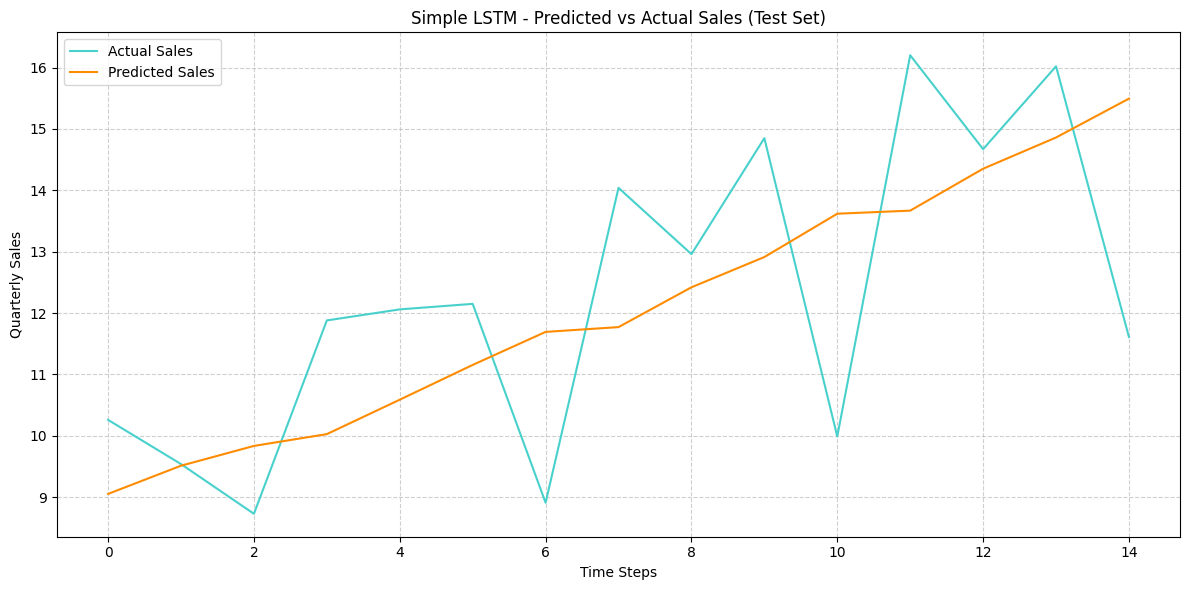

In [5]:
# -------------------------------------------------
# Normalize the JJ Sales Data for LSTM Input
# -------------------------------------------------
scaler = MinMaxScaler()
jj_data[['Sales']] = scaler.fit_transform(jj_data[['Sales']])

# -------------------------------------------------
# Generate Sequences for Supervised LSTM Learning
# -------------------------------------------------
def create_lstm_sequences(data, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])
        y_seq.append(data[i + window_size])
    return np.array(X_seq), np.array(y_seq)

seq_length = 12  # Use 12 past quarters as input
X_seq, y_seq = create_lstm_sequences(jj_data['Sales'].values, seq_length)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))  # Reshape for LSTM

# -------------------------------------------------
# Train-Test Split (No Shuffle for Time Series)
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# -------------------------------------------------
# Define and Train a Simple LSTM Network
# -------------------------------------------------
lstm_simple = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_simple.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------------------------
# Function to Plot LSTM Predictions vs Actuals
# -------------------------------------------------
def plot_lstm_forecast(model, X_eval, y_eval, label="Simple LSTM"):
    predictions = model.predict(X_eval)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_eval.reshape(-1, 1)), label='Actual Sales', color='mediumturquoise')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted Sales', color='darkorange')
    plt.title(f"{label} - Predicted vs Actual Sales (Test Set)")
    plt.xlabel("Time Steps")
    plt.ylabel("Quarterly Sales")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Display the Prediction Plot
# -------------------------------------------------
plot_lstm_forecast(lstm_simple, X_test, y_test, "Simple LSTM")


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# -------------------------------------------------
# Predict on Test Set and Inverse Transform
# -------------------------------------------------
lstm_test_preds_scaled = lstm_simple.predict(X_test)

# Convert predictions and ground truth back to original scale
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_preds_unscaled = scaler.inverse_transform(lstm_test_preds_scaled).flatten()

# -------------------------------------------------
# Compute Evaluation Metrics
# -------------------------------------------------
mae = mean_absolute_error(y_test_unscaled, y_preds_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_preds_unscaled))
mape = mean_absolute_percentage_error(y_test_unscaled, y_preds_unscaled)

# -------------------------------------------------
# Output Model Performance
# -------------------------------------------------
print(" LSTM Model Performance on Test Set")
print(f" Mean Absolute Error (MAE)       : {mae:.4f}")
print(f" Root Mean Squared Error (RMSE) : {rmse:.4f}")
print(f" Mean Absolute Percentage Error : {mape:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
 LSTM Model Performance on Test Set
 Mean Absolute Error (MAE)       : 1.7138
 Root Mean Squared Error (RMSE) : 2.0380
 Mean Absolute Percentage Error : 0.1467


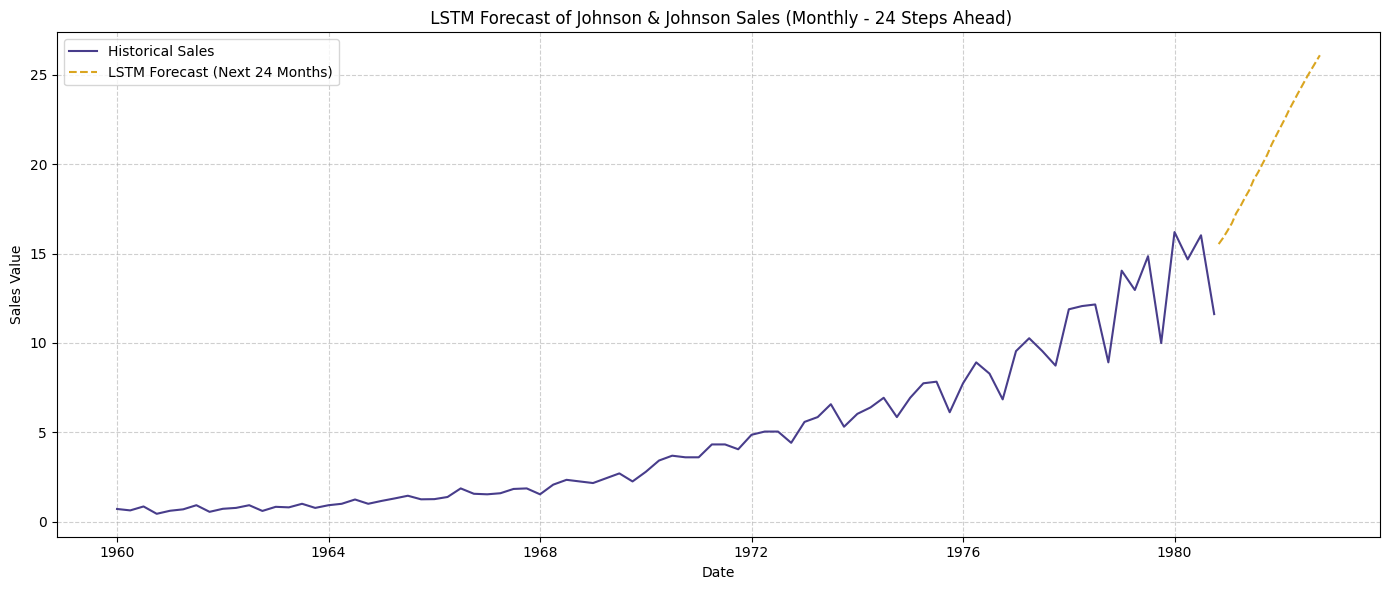

In [10]:
# -------------------------------------------------
# Function: Forecast Future Sales Using LSTM
# -------------------------------------------------
def forecast_future(model, scaled_series, scaler, n_future=24, seq_len=12):
    """
    Forecast future values using a trained LSTM model.

    Parameters:
        model      : Trained LSTM model
        scaled_series : Scaled time series data
        scaler     : Fitted MinMaxScaler object
        n_future   : Number of future steps to forecast
        seq_len    : Input sequence length (timesteps)

    Returns:
        np.array: Forecasted values (inverse-transformed)
    """
    input_seq = scaled_series[-seq_len:].reshape(1, seq_len, 1)
    future_preds = []

    for _ in range(n_future):
        pred = model.predict(input_seq, verbose=0)[0][0]
        future_preds.append(pred)
        input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# -------------------------------------------------
# Scale Full Series for Forecasting Input
# -------------------------------------------------
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(jj_df['value'].values.reshape(-1, 1))

# Generate Forecast for Next 24 Months
future_preds = forecast_future(
    model=lstm_simple,
    scaled_series=scaled_series,
    scaler=scaler,
    n_future=24,
    seq_len=12
)

# Create Monthly Date Index for Future Predictions
start_date = jj_df.index[-1] + pd.DateOffset(months=1)
future_index = pd.date_range(start=start_date, periods=24, freq='MS')

# -------------------------------------------------
# Plot LSTM Forecast vs Historical Sales
# -------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(jj_df.index, scaler.inverse_transform(scaled_series), label='Historical Sales', color='darkslateblue')
plt.plot(future_index, future_preds, label='LSTM Forecast (Next 24 Months)', color='goldenrod', linestyle='--')
plt.title(' LSTM Forecast of Johnson & Johnson Sales (Monthly - 24 Steps Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
